In [73]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns

In [74]:
# Display options for better readability, being a large dataset
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [75]:
# combine the csv files into one dataframe
data_path = 'data/*.csv'
files = glob.glob(data_path)

df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

df.to_csv('data/combined_data.csv', index=False)

In [76]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFH,BFD,BFA,1XBH,1XBD,1XBA,BFEH,BFED,BFEA,BFE>2.5,BFE<2.5,BFEAHH,BFEAHA,BFCH,BFCD,BFCA,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA
0,P1,18/09/2020,19:00,Famalicao,Benfica,1,5,A,0,3,A,6,13,2,7,14,10,3,4,1,2,0,0,7.50,5.00,1.36,7.50,5.0,1.40,7.00,4.70,1.43,8.30,4.92,1.41,8.00,4.75,1.38,7.50,4.5,1.4,8.30,5.00,1.44,7.55,4.72,1.39,1.70,2.10,1.71,2.22,1.76,2.25,1.69,2.16,1.25,2.00,1.90,2.00,1.90,2.01,1.96,1.95,1.88,8.00,5.00,1.33,7.50,5.0,1.40,7.50,4.90,1.40,9.34,5.18,1.36,9.50,4.8,1.33,8.50,4.8,1.33,9.64,5.43,1.40,8.34,4.95,1.35,1.61,2.25,1.64,2.35,1.70,2.35,1.64,2.25,1.50,1.84,2.06,1.86,2.06,1.87,2.08,1.81,2.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P1,18/09/2020,21:15,Guimaraes,Belenenses,0,1,A,0,0,D,11,4,2,3,14,20,7,2,1,4,0,0,1.45,4.33,7.00,1.44,4.2,7.25,1.50,4.20,6.50,1.51,4.31,7.29,1.44,4.33,7.50,1.40,4.5,7.5,1.55,4.50,7.50,1.48,4.20,6.74,1.85,1.95,1.89,2.00,1.89,2.15,1.81,2.00,-1.00,1.85,2.05,1.87,2.04,1.88,2.15,1.82,2.01,1.45,4.33,7.00,1.44,4.2,7.25,1.53,4.20,6.50,1.52,4.37,7.02,1.47,4.2,7.00,1.50,4.0,6.50,1.54,4.47,7.53,1.49,4.15,6.68,1.95,1.85,1.99,1.90,2.03,2.09,1.91,1.88,-1.00,1.91,1.99,1.89,2.02,1.94,2.04,1.86,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P1,19/09/2020,16:00,Nacional,Boavista,3,3,D,2,2,D,14,8,7,3,24,21,6,4,4,3,0,0,2.55,3.10,2.87,2.55,3.1,2.85,2.55,3.00,2.95,2.60,3.09,3.02,2.55,3.00,3.00,2.55,3.0,2.9,2.63,3.19,3.12,2.55,3.01,2.94,2.50,1.50,2.59,1.52,2.63,1.55,2.54,1.50,0.00,1.83,2.07,1.80,2.09,1.89,2.11,1.79,2.05,2.55,3.10,2.87,2.55,3.1,2.85,2.65,2.95,2.85,2.75,3.02,3.01,2.62,3.0,2.88,2.60,3.0,2.88,2.75,3.20,3.10,2.63,2.99,2.88,2.50,1.50,2.67,1.52,2.67,1.57,2.55,1.50,0.00,1.84,2.06,1.87,2.05,1.89,2.09,1.84,2.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P1,19/09/2020,21:00,Porto,Sp Braga,3,1,H,2,1,H,11,7,4,1,17,18,5,1,0,0,0,0,1.61,4.00,5.00,1.62,4.0,5.50,1.63,3.90,5.50,1.62,3.95,5.82,1.60,3.90,5.50,1.62,4.0,5.0,1.66,4.13,5.92,1.62,3.92,5.24,1.72,2.07,1.79,2.07,1.81,2.17,1.76,2.06,-0.75,1.83,2.07,1.80,2.08,1.86,2.12,1.79,2.04,1.61,4.00,5.00,1.62,4.0,5.50,1.70,3.85,4.90,1.69,4.02,5.20,1.63,4.0,5.00,1.65,3.9,4.80,1.72,4.16,5.53,1.66,3.89,4.98,1.72,2.07,1.78,2.11,1.81,2.20,1.74,2.08,-0.75,1.89,2.01,1.90,2.01,1.90,2.04,1.86,1.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P1,20/09/2020,16:00,Santa Clara,Maritimo,2,0,H,0,0,D,12,12,5,2,15,17,5,6,2,1,0,0,2.10,3.20,3.60,2.20,3.1,3.40,2.25,2.95,3.55,2.29,3.01,3.71,2.15,3.20,3.50,2.15,3.2,3.4,2.31,3.32,3.91,2.21,3.06,3.50,2.25,1.61,2.32,1.64,2.35,1.67,2.26,1.62,-0.25,1.92,1.98,1.93,1.95,1.95,2.04,1.88,1.94,2.37,3.00,3.20,2.20,3.1,3.40,2.40,2.90,3.30,2.49,2.97,3.45,2.35,3.0,3.30,2.30,3.0,3.30,2.49,3.16,3.60,2.38,2.94,3.31,2.70,1.44,2.88,1.46,2.88,1.53,2.69,1.46,-0.25,2.08,1.82,2.08,1.84,2.11,1.96,2.02,1.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
df.info(verbose=True, show_counts=True) #using parameter verbose=True to show all columns and show_counts for their counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467 entries, 0 to 1466
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1467 non-null   object 
 1   HomeTeam   1467 non-null   object 
 2   AwayTeam   1467 non-null   object 
 3   FTHG       1467 non-null   int64  
 4   FTAG       1467 non-null   int64  
 5   FTR        1467 non-null   object 
 6   HTHG       1467 non-null   int64  
 7   HTAG       1467 non-null   int64  
 8   HTR        1467 non-null   object 
 9   HS         1467 non-null   int64  
 10  AS         1467 non-null   int64  
 11  HST        1467 non-null   int64  
 12  AST        1467 non-null   int64  
 13  HF         1467 non-null   int64  
 14  AF         1467 non-null   int64  
 15  HC         1467 non-null   int64  
 16  AC         1467 non-null   int64  
 17  HY         1467 non-null   int64  
 18  AY         1467 non-null   int64  
 19  HR         1467 non-null   int64  
 20  AR      

In [78]:
df.count()

Div          1467
Date         1467
Time         1467
HomeTeam     1467
AwayTeam     1467
FTHG         1467
FTAG         1467
FTR          1467
HTHG         1467
HTAG         1467
HTR          1467
HS           1467
AS           1467
HST          1467
AST          1467
HF           1467
AF           1467
HC           1467
AC           1467
HY           1467
AY           1467
HR           1467
AR           1467
B365H        1465
B365D        1465
B365A        1465
BWH          1398
BWD          1398
BWA          1398
IWH          1052
IWD          1052
IWA          1052
PSH          1465
PSD          1465
PSA          1465
WHH          1456
WHD          1456
WHA          1456
VCH          1222
VCD          1222
VCA          1222
MaxH         1467
MaxD         1467
MaxA         1467
AvgH         1467
AvgD         1467
AvgA         1467
B365>2.5     1466
B365<2.5     1466
P>2.5        1465
P<2.5        1465
Max>2.5      1467
Max<2.5      1467
Avg>2.5      1467
Avg<2.5      1467
AHh       

<Axes: >

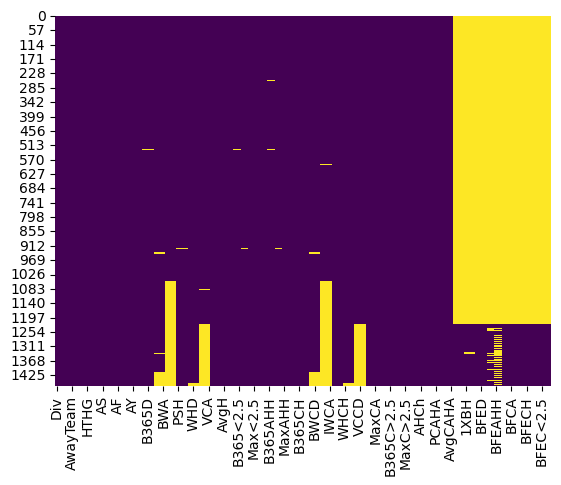

In [79]:
#Verify if there are any missing values
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

In [80]:
df.isnull().sum()

Div             0
Date            0
Time            0
HomeTeam        0
AwayTeam        0
FTHG            0
FTAG            0
FTR             0
HTHG            0
HTAG            0
HTR             0
HS              0
AS              0
HST             0
AST             0
HF              0
AF              0
HC              0
AC              0
HY              0
AY              0
HR              0
AR              0
B365H           2
B365D           2
B365A           2
BWH            69
BWD            69
BWA            69
IWH           415
IWD           415
IWA           415
PSH             2
PSD             2
PSA             2
WHH            11
WHD            11
WHA            11
VCH           245
VCD           245
VCA           245
MaxH            0
MaxD            0
MaxA            0
AvgH            0
AvgD            0
AvgA            0
B365>2.5        1
B365<2.5        1
P>2.5           2
P<2.5           2
Max>2.5         0
Max<2.5         0
Avg>2.5         0
Avg<2.5         0
AHh       

DATA CLEANING

In [81]:
# Drop non-essential columns
# remove time, not relevant for analysis
# remove div, same value for all
# remove recent betting houses, low data
# remove all betting odds but one, similar values (keep bet365)
# remove first betting odds, maintain only recent ones (represented with "c" after the name)

# resume: remove div, time and all betting odds but one (bet365c)


remove_columns = ['Div','Time']

df = df.drop(columns=remove_columns)

# drop columns with at least one NaN value
df = df.dropna(axis=1)


prefix_to_remove = ['Max','Avg','AH']

# remove columns with prefix "Max", "Avg" or "AH"
for prefix in prefix_to_remove:
    cols_to_drop = [col for col in df.columns if col.startswith(prefix)]
    df = df.drop(columns=cols_to_drop)


In [86]:
# Verify duplicated rows

duplicadas = df[df.duplicated()]
print(f"Duplicated rows: {len(duplicadas)}")
print("Duplicated by game (HomeTeam, AwayTeam, Date):", df.duplicated(subset=['HomeTeam', 'AwayTeam', 'Date']).sum())

Duplicated rows: 0
Duplicated by game (HomeTeam, AwayTeam, Date): 0
